In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import sys
import time
from collections import namedtuple, defaultdict
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import cPickle as pickle

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model

import logging
from logging import info


import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *
from thesis.utils.file import *

Using Theano backend.
Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
RANDOM_SEED = 10000
NN_SEED = 1234
random.seed(RANDOM_SEED)

MAX_TERMS = 10000

In [4]:
NUM_CORES = 16

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
NN_PARAMETER_SEARCH_PREFIX = "nn_lda_{}_batch_{}_nn_parameter_searches.pkl"

In [7]:
root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"
lda_location = "/mnt/data/shalaby/" + "extended_pv_lda/"

nn_parameter_search_location = os.path.join(root_location, "nn_lda_parameter_search")

classifications_index_file = exports_location + "classifications_index.pkl"
doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

In [8]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_label_data(classifications, doc_ids, doc_classification_map):
    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    data_labels = []
    for i, doc_id in enumerate(doc_ids):
        eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
        data_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))
        #if i % 1000 == 0: info(i)
    data_labels = np.array(data_labels, dtype=np.int8)
    return data_labels

In [9]:
def create_keras_nn_model(input_size, output_size, 
                          first_hidden_layer_size, first_hidden_layer_activation, 
                          second_hidden_layer_size, second_hidden_layer_activation, 
                          input_dropout_do, hidden_dropout_do, second_hidden_dropout_do=False):
    
    doc_input = Input(shape=(input_size,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                   name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    if second_hidden_layer_size is not None:
        hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                       name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
    if second_hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    softmax_output = Dense(output_size, activation='sigmoid', name='softmax_output')(hidden)

    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return model

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 17.8 s, sys: 832 ms, total: 18.7 s
Wall time: 18.7 s


In [11]:
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
early_stopper_patience = {
    'sections': 10,
    'classes': 15,
    'subclasses': 15
}
epochs_before_validation = {
    'sections': 5,
    'classes': 20,
    'subclasses': 20
}

# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.5},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [12]:
class MetricsCallbackWithGenerator(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    def __init__(self):
        MetricsCallbackWithGenerator.EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
        MetricsCallbackWithGenerator.GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
        MetricsCallbackWithGenerator.GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallbackWithGenerator.GRAPH_MIN, MetricsCallbackWithGenerator.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            #print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallbackWithGenerator.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict_generator(generator=nn_batch_generator(Xv, yv, NN_BATCH_SIZE), 
                                                   val_samples=Xv.shape[0])
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

In [13]:
def nn_batch_generator_with_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(shuffle_index)
    X_data =  X_data[shuffle_index, :]
    y_data =  y_data[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter > number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
#         X_batch = X_data[index_batch,:].todense()
        X_batch = X_data[index_batch,:]
        y_batch = y_data[index_batch]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0

## Training and Validation Loop

In [32]:
classifications = valid_subclasses
classifications_type = "subclasses"

In [33]:
NN_OUTPUT_NEURONS = len(classifications)
# NN_INPUT_NEURONS = DOC2VEC_SIZE

EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

NN_MAX_EPOCHS = 200
NN_RANDOM_SEARCH_BUDGET = 20
NN_PARAM_SAMPLE_SEED = 1234

NN_BATCH_SIZE = 2048

MODEL_VERBOSITY = 1

to_skip = ['nn_1st-size_100_1st-act_sigmoid_2nd-size_1000_2nd-act_tanh_in-drop_False_hid-drop_True']

load_existing_results = True
save_results = True


first_hidden_layer_sizes = [100,200,500,1000]
# first_hidden_layer_sizes = [1000,2000]
# second_hidden_layer_sizes = [1000,2000,3000,4000]
second_hidden_layer_sizes = [None,500,1000,2000]
first_hidden_layer_activations = ['relu','sigmoid', 'tanh']
second_hidden_layer_activations = ['relu','sigmoid', 'tanh']
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
# input_dropout_options = [False, True]
# hidden_dropout_options = [False, True]
input_dropout_options = [False]
hidden_dropout_options = [True]
second_hidden_dropout_options = [False]


np.random.seed(NN_SEED)


# Uncomment for Specific Configuration
# NN_RANDOM_SEARCH_BUDGET = 1
# first_hidden_layer_sizes = [500]
# second_hidden_layer_sizes = [2000]
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
# input_dropout_options = [False]
# hidden_dropout_options = [True]
# second_hidden_dropout_options = [False]

In [34]:
LDA_TOPICS = 1000
LDA_ITERATIONS = 50
LDA_BATCH_SIZE = 4096
LDA_DECAY = 0.5
LDA_EVALUATE_EVERY = 1000
LDA_VERBOSE = 2
LDA_LEARNING_METHOD = 'online'
LDA_MODEL_NAME = "lda_{}_topics_{}_iter_{}_batch_{}_decay_{}_evaluate-every_{}".format(LDA_LEARNING_METHOD, 
                                                                                       LDA_TOPICS, LDA_ITERATIONS,
                                                                                       LDA_BATCH_SIZE, LDA_DECAY, 
                                                                                       LDA_EVALUATE_EVERY)

In [36]:
%matplotlib notebook

2017-04-10 15:52:10,562 : INFO : =============== bm25 Being Evaluated ================
2017-04-10 15:52:10,564 : INFO : Getting Training Data
2017-04-10 15:55:36,962 : INFO : Getting Validation Data


CPU times: user 1min 4s, sys: 8.06 s, total: 1min 12s
Wall time: 3min 24s
(1286325, 1000)
(1286325, 940)


2017-04-10 15:55:51,197 : INFO : No Previous results exist in /mnt/data2/shalaby/nn_lda_parameter_search/bm25/lda_online_topics_1000_iter_50_batch_4096_decay_0.5_evaluate-every_1000/nn_lda_subclasses_batch_2048_nn_parameter_searches.pkl
2017-04-10 15:55:51,198 : INFO : ***************************************************************************************
2017-04-10 15:55:51,199 : INFO : nn_1st-size_100_1st-act_relu_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


CPU times: user 13.6 s, sys: 400 ms, total: 14 s
Wall time: 13.8 s
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 100)           100100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_40 (Dropout)             (None, 100)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          101000      dropout_40[0][0]                 
________________________

<IPython.core.display.Javascript object>


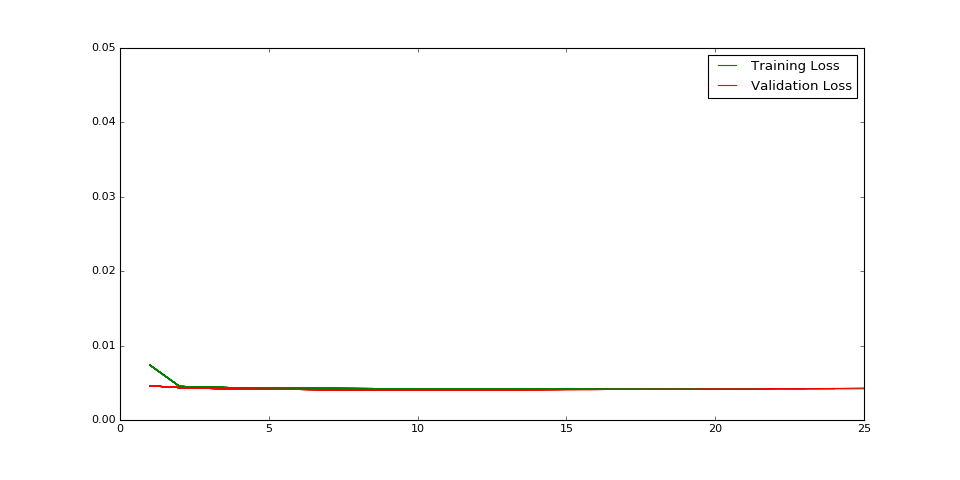

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0074

2017-04-10 15:56:09,021 : INFO : Found lower val loss for epoch 1 => 0.0046


1286325/1286325 [==============================] - 16s - loss: 0.0074 - val_loss: 0.0046
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0045

2017-04-10 15:56:25,071 : INFO : Found lower val loss for epoch 2 => 0.00435


1286325/1286325 [==============================] - 16s - loss: 0.0045 - val_loss: 0.0044
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0044

2017-04-10 15:56:40,921 : INFO : Found lower val loss for epoch 3 => 0.00424


1286325/1286325 [==============================] - 15s - loss: 0.0044 - val_loss: 0.0042
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 15:56:56,883 : INFO : Found lower val loss for epoch 4 => 0.00418


1286325/1286325 [==============================] - 15s - loss: 0.0043 - val_loss: 0.0042
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 15:57:12,427 : INFO : Found lower val loss for epoch 5 => 0.00414


1286325/1286325 [==============================] - 15s - loss: 0.0043 - val_loss: 0.0041
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 15:57:28,467 : INFO : Found lower val loss for epoch 6 => 0.00411


1286325/1286325 [==============================] - 16s - loss: 0.0043 - val_loss: 0.0041
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 15:57:44,117 : INFO : Found lower val loss for epoch 7 => 0.00408


1286325/1286325 [==============================] - 15s - loss: 0.0043 - val_loss: 0.0041
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 15:58:00,003 : INFO : Found lower val loss for epoch 8 => 0.00407


1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 15:58:16,218 : INFO : Found lower val loss for epoch 9 => 0.00404


1286325/1286325 [==============================] - 16s - loss: 0.0042 - val_loss: 0.0040
Epoch 10/200
1286325/1286325 [==============================] - 16s - loss: 0.0042 - val_loss: 0.0040
Epoch 11/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0040
Epoch 12/200
1286325/1286325 [==============================] - 16s - loss: 0.0042 - val_loss: 0.0040
Epoch 13/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 14/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 15/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 16/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 17/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 18/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 

2017-04-10 16:02:28,982 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00024: early stopping
CPU times: user 5min 29s, sys: 3min 54s, total: 9min 24s
Wall time: 6min 37s


2017-04-10 16:03:27,770 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 11.549 | Top 3: 0.652 | Top 5: 0.736 | F1 Micro: 0.405 | F1 Macro: 0.040


2017-04-10 16:05:39,001 : INFO : ***************************************************************************************
2017-04-10 16:05:39,003 : INFO : nn_1st-size_100_1st-act_tanh_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 100)           100100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_41 (Dropout)             (None, 100)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 500)           50500       dropout_41[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


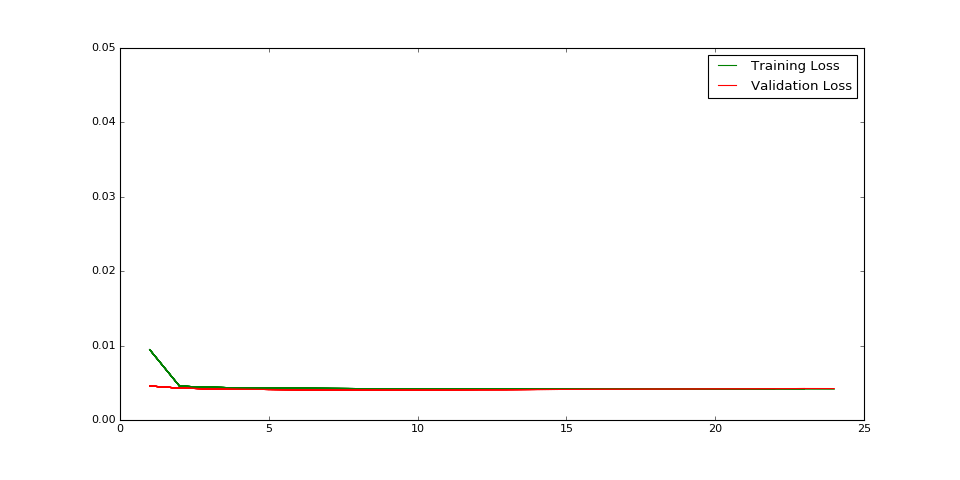

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0094

2017-04-10 16:05:59,147 : INFO : Found lower val loss for epoch 1 => 0.00457


1286325/1286325 [==============================] - 14s - loss: 0.0094 - val_loss: 0.0046
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0046

2017-04-10 16:06:14,297 : INFO : Found lower val loss for epoch 2 => 0.00428


1286325/1286325 [==============================] - 15s - loss: 0.0046 - val_loss: 0.0043
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0044

2017-04-10 16:06:29,039 : INFO : Found lower val loss for epoch 3 => 0.0042


1286325/1286325 [==============================] - 14s - loss: 0.0044 - val_loss: 0.0042
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 16:06:43,613 : INFO : Found lower val loss for epoch 4 => 0.00413


1286325/1286325 [==============================] - 14s - loss: 0.0043 - val_loss: 0.0041
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 16:06:58,879 : INFO : Found lower val loss for epoch 5 => 0.0041


1286325/1286325 [==============================] - 15s - loss: 0.0043 - val_loss: 0.0041
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 16:07:13,752 : INFO : Found lower val loss for epoch 6 => 0.00408


1286325/1286325 [==============================] - 14s - loss: 0.0043 - val_loss: 0.0041
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 16:07:29,017 : INFO : Found lower val loss for epoch 7 => 0.00407


1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 16:07:43,869 : INFO : Found lower val loss for epoch 8 => 0.00406


1286325/1286325 [==============================] - 14s - loss: 0.0042 - val_loss: 0.0041
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 16:07:59,733 : INFO : Found lower val loss for epoch 9 => 0.00405


1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 10/200
1286325/1286325 [==============================] - 14s - loss: 0.0042 - val_loss: 0.0041
Epoch 11/200
1286325/1286325 [==============================] - 14s - loss: 0.0042 - val_loss: 0.0041
Epoch 12/200
1286325/1286325 [==============================] - 14s - loss: 0.0042 - val_loss: 0.0041
Epoch 13/200
1286325/1286325 [==============================] - 14s - loss: 0.0042 - val_loss: 0.0041
Epoch 14/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 15/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 16/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 17/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 0.0041
Epoch 18/200
1286325/1286325 [==============================] - 15s - loss: 0.0042 - val_loss: 

2017-04-10 16:11:43,297 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00023: early stopping
CPU times: user 5min 13s, sys: 3min 31s, total: 8min 44s
Wall time: 6min 3s


2017-04-10 16:12:40,759 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 11.338 | Top 3: 0.656 | Top 5: 0.740 | F1 Micro: 0.468 | F1 Macro: 0.062


2017-04-10 16:14:47,350 : INFO : ***************************************************************************************
2017-04-10 16:14:47,353 : INFO : nn_1st-size_200_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200)           200200      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_42 (Dropout)             (None, 200)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          402000      dropout_42[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


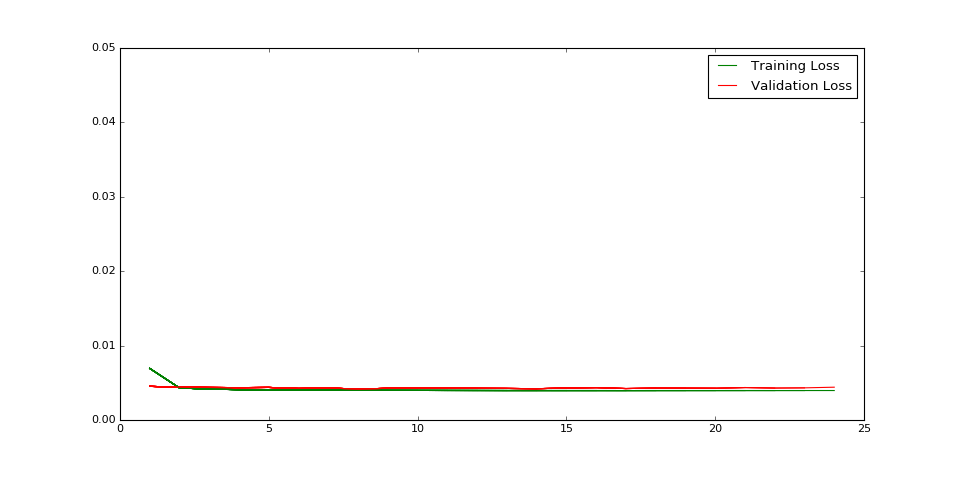

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0069

2017-04-10 16:15:07,951 : INFO : Found lower val loss for epoch 1 => 0.00452


1286325/1286325 [==============================] - 19s - loss: 0.0069 - val_loss: 0.0045
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 16:15:27,332 : INFO : Found lower val loss for epoch 2 => 0.00441


1286325/1286325 [==============================] - 19s - loss: 0.0043 - val_loss: 0.0044
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 16:15:46,387 : INFO : Found lower val loss for epoch 3 => 0.00437


1286325/1286325 [==============================] - 19s - loss: 0.0041 - val_loss: 0.0044
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 16:16:06,275 : INFO : Found lower val loss for epoch 4 => 0.00435


1286325/1286325 [==============================] - 19s - loss: 0.0041 - val_loss: 0.0044
Epoch 5/200
1286325/1286325 [==============================] - 18s - loss: 0.0040 - val_loss: 0.0044
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:16:43,795 : INFO : Found lower val loss for epoch 6 => 0.00424


1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0042
Epoch 7/200
1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0043
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:17:22,136 : INFO : Found lower val loss for epoch 8 => 0.00415


1286325/1286325 [==============================] - 18s - loss: 0.0040 - val_loss: 0.0042
Epoch 9/200
1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0043
Epoch 10/200
1286325/1286325 [==============================] - 18s - loss: 0.0040 - val_loss: 0.0043
Epoch 11/200
1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0043
Epoch 12/200
1286325/1286325 [==============================] - 18s - loss: 0.0040 - val_loss: 0.0043
Epoch 13/200
1286325/1286325 [==============================] - 18s - loss: 0.0040 - val_loss: 0.0042
Epoch 14/200
1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0042
Epoch 15/200
1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0043
Epoch 16/200
1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0044
Epoch 17/200
1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0

2017-04-10 16:22:34,574 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00023: early stopping
CPU times: user 5min 35s, sys: 4min 52s, total: 10min 28s
Wall time: 7min 46s


2017-04-10 16:23:33,189 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 10.328 | Top 3: 0.677 | Top 5: 0.761 | F1 Micro: 0.468 | F1 Macro: 0.069


2017-04-10 16:25:59,596 : INFO : ***************************************************************************************
2017-04-10 16:25:59,600 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          1001000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_43 (Dropout)             (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           940940      dropout_43[0][0]                 
Total params: 1941940
_____________________________________________________________________

<IPython.core.display.Javascript object>


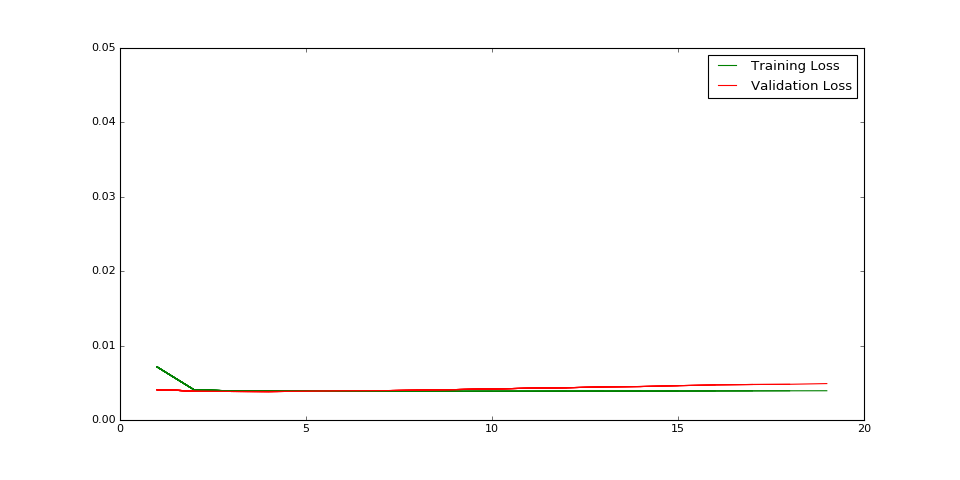

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0071

2017-04-10 16:26:17,853 : INFO : Found lower val loss for epoch 1 => 0.00407


1286325/1286325 [==============================] - 16s - loss: 0.0071 - val_loss: 0.0041
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:26:36,047 : INFO : Found lower val loss for epoch 2 => 0.0039


1286325/1286325 [==============================] - 18s - loss: 0.0040 - val_loss: 0.0039
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:26:53,346 : INFO : Found lower val loss for epoch 3 => 0.00384


1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:27:10,831 : INFO : Found lower val loss for epoch 4 => 0.00383


1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 5/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0039
Epoch 6/200
1286325/1286325 [==============================] - 16s - loss: 0.0038 - val_loss: 0.0039
Epoch 7/200
1286325/1286325 [==============================] - 16s - loss: 0.0038 - val_loss: 0.0039
Epoch 8/200
1286325/1286325 [==============================] - 16s - loss: 0.0038 - val_loss: 0.0040
Epoch 9/200
1286325/1286325 [==============================] - 16s - loss: 0.0038 - val_loss: 0.0041
Epoch 10/200
1286325/1286325 [==============================] - 15s - loss: 0.0038 - val_loss: 0.0042
Epoch 11/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0043
Epoch 12/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0043
Epoch 13/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.004

2017-04-10 16:31:17,377 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00018: early stopping
CPU times: user 4min 14s, sys: 3min 13s, total: 7min 28s
Wall time: 5min 17s


2017-04-10 16:32:13,914 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.935 | Top 3: 0.688 | Top 5: 0.771 | F1 Micro: 0.431 | F1 Macro: 0.062


2017-04-10 16:34:43,656 : INFO : ***************************************************************************************
2017-04-10 16:34:43,659 : INFO : nn_1st-size_200_1st-act_tanh_2nd-size_500_2nd-act_tanh_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           200200      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_44 (Dropout)             (None, 200)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_tanh (Dense)       (None, 500)           100500      dropout_44[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


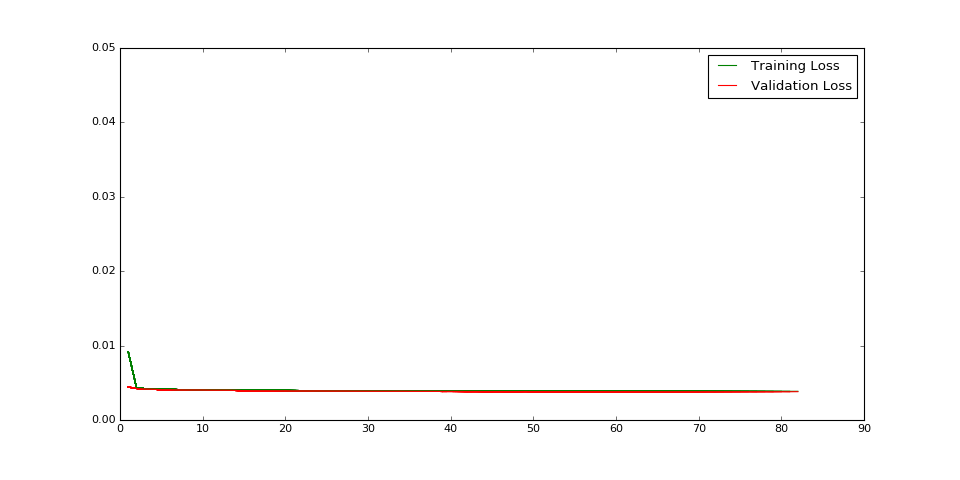

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0091

2017-04-10 16:35:02,506 : INFO : Found lower val loss for epoch 1 => 0.00443


1286325/1286325 [==============================] - 17s - loss: 0.0091 - val_loss: 0.0044
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 16:35:19,152 : INFO : Found lower val loss for epoch 2 => 0.00424


1286325/1286325 [==============================] - 16s - loss: 0.0043 - val_loss: 0.0042
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 16:35:35,616 : INFO : Found lower val loss for epoch 3 => 0.00417


1286325/1286325 [==============================] - 16s - loss: 0.0042 - val_loss: 0.0042
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 16:35:52,546 : INFO : Found lower val loss for epoch 4 => 0.00412


1286325/1286325 [==============================] - 16s - loss: 0.0042 - val_loss: 0.0041
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 16:36:09,665 : INFO : Found lower val loss for epoch 5 => 0.00408


1286325/1286325 [==============================] - 17s - loss: 0.0041 - val_loss: 0.0041
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 16:36:26,610 : INFO : Found lower val loss for epoch 6 => 0.00408


1286325/1286325 [==============================] - 16s - loss: 0.0041 - val_loss: 0.0041
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 16:36:43,147 : INFO : Found lower val loss for epoch 7 => 0.00406


1286325/1286325 [==============================] - 16s - loss: 0.0041 - val_loss: 0.0041
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 16:37:00,549 : INFO : Found lower val loss for epoch 8 => 0.00404


1286325/1286325 [==============================] - 17s - loss: 0.0041 - val_loss: 0.0040
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 16:37:16,695 : INFO : Found lower val loss for epoch 9 => 0.00404


1286325/1286325 [==============================] - 16s - loss: 0.0041 - val_loss: 0.0040
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:37:33,486 : INFO : Found lower val loss for epoch 10 => 0.00403


1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0040
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:37:50,220 : INFO : Found lower val loss for epoch 11 => 0.004


1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0040
Epoch 12/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:38:06,316 : INFO : Found lower val loss for epoch 12 => 0.004


1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0040
Epoch 13/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:38:23,549 : INFO : Found lower val loss for epoch 13 => 0.00399


1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0040
Epoch 14/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:38:39,545 : INFO : Found lower val loss for epoch 14 => 0.00397


1286325/1286325 [==============================] - 15s - loss: 0.0040 - val_loss: 0.0040
Epoch 15/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:38:56,268 : INFO : Found lower val loss for epoch 15 => 0.00395


1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0040
Epoch 16/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:39:13,024 : INFO : Found lower val loss for epoch 16 => 0.00394


1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0039
Epoch 17/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:39:30,358 : INFO : Found lower val loss for epoch 17 => 0.00394


1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0039
Epoch 18/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:39:46,600 : INFO : Found lower val loss for epoch 18 => 0.00393


1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0039
Epoch 19/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:40:03,881 : INFO : Found lower val loss for epoch 19 => 0.00393


1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0039
Epoch 20/200
1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0039
Epoch 21/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:40:36,956 : INFO : Found lower val loss for epoch 21 => 0.00392
2017-04-10 16:40:36,957 : INFO : Validation Loss Reduced 20 times
2017-04-10 16:40:36,959 : INFO : Evaluating on Validation Data
2017-04-10 16:41:34,888 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 10.539 | Top 3: 0.669 | Top 5: 0.754 | F1 Micro: 0.441 | F1 Macro: 0.066
1286325/1286325 [==============================] - 225s - loss: 0.0040 - val_loss: 0.0039
Epoch 22/200
1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0039
Epoch 23/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 16:44:41,788 : INFO : Found lower val loss for epoch 23 => 0.00392


1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0039
Epoch 24/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0039
Epoch 25/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:45:16,239 : INFO : Found lower val loss for epoch 25 => 0.0039


1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0039
Epoch 26/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:45:32,660 : INFO : Found lower val loss for epoch 26 => 0.0039


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0039
Epoch 27/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0039
Epoch 28/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:46:06,898 : INFO : Found lower val loss for epoch 28 => 0.00389


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0039
Epoch 29/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:46:23,779 : INFO : Found lower val loss for epoch 29 => 0.00388


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0039
Epoch 30/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:46:40,730 : INFO : Found lower val loss for epoch 30 => 0.00387


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0039
Epoch 31/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:46:57,223 : INFO : Found lower val loss for epoch 31 => 0.00387


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0039
Epoch 32/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:47:14,262 : INFO : Found lower val loss for epoch 32 => 0.00386


1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0039
Epoch 33/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:47:30,439 : INFO : Found lower val loss for epoch 33 => 0.00386


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0039
Epoch 34/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0039
Epoch 35/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:48:04,140 : INFO : Found lower val loss for epoch 35 => 0.00385


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0039
Epoch 36/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:48:20,821 : INFO : Found lower val loss for epoch 36 => 0.00385


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 37/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:48:38,100 : INFO : Found lower val loss for epoch 37 => 0.00385


1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 38/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:48:54,310 : INFO : Found lower val loss for epoch 38 => 0.00384


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 39/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:49:10,796 : INFO : Found lower val loss for epoch 39 => 0.00384


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 40/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 41/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:49:44,162 : INFO : Found lower val loss for epoch 41 => 0.00383


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 42/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:50:00,479 : INFO : Found lower val loss for epoch 42 => 0.00383


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 43/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 44/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:50:34,159 : INFO : Found lower val loss for epoch 44 => 0.00382


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 45/200
1286325/1286325 [==============================] - 15s - loss: 0.0039 - val_loss: 0.0038
Epoch 46/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 47/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:51:23,001 : INFO : Found lower val loss for epoch 47 => 0.00382


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 48/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:51:39,956 : INFO : Found lower val loss for epoch 48 => 0.00382


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 49/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 50/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:52:12,625 : INFO : Found lower val loss for epoch 50 => 0.00382
2017-04-10 16:52:12,627 : INFO : Validation Loss Reduced 40 times
2017-04-10 16:52:12,628 : INFO : Evaluating on Validation Data
2017-04-10 16:53:10,668 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 10.061 | Top 3: 0.679 | Top 5: 0.763 | F1 Micro: 0.476 | F1 Macro: 0.081
1286325/1286325 [==============================] - 227s - loss: 0.0039 - val_loss: 0.0038
Epoch 51/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 52/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:56:18,265 : INFO : Found lower val loss for epoch 52 => 0.00381


1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 53/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 54/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 55/200
1286325/1286325 [==============================] - 15s - loss: 0.0039 - val_loss: 0.0038
Epoch 56/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 57/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:57:41,557 : INFO : Found lower val loss for epoch 57 => 0.00381


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 58/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 59/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:58:16,297 : INFO : Found lower val loss for epoch 59 => 0.00381


1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 60/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 16:58:33,169 : INFO : Found lower val loss for epoch 60 => 0.0038


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 61/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 62/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 63/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 64/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 65/200
1286325/1286325 [==============================] - 15s - loss: 0.0039 - val_loss: 0.0038
Epoch 66/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 17:00:11,781 : INFO : Found lower val loss for epoch 66 => 0.0038


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 67/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 68/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 69/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 70/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 71/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 72/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0038
Epoch 73/200
1286325/1286325 [==============================] - 18s - loss: 0.0039 - val_loss: 0.0038
Epoch 74/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 75/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 

2017-04-10 17:03:54,224 : INFO : Found lower val loss for epoch 79 => 0.0038


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 80/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 81/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 17:04:26,994 : INFO : Found lower val loss for epoch 81 => 0.0038


1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038
Epoch 82/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0038

2017-04-10 17:04:43,561 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00081: early stopping
CPU times: user 24min 22s, sys: 15min 9s, total: 39min 31s
Wall time: 29min 59s


2017-04-10 17:05:44,159 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.954 | Top 3: 0.681 | Top 5: 0.765 | F1 Micro: 0.487 | F1 Macro: 0.088


2017-04-10 17:08:18,979 : INFO : ***************************************************************************************
2017-04-10 17:08:18,985 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_None_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          1001000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_45 (Dropout)             (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           940940      dropout_45[0][0]                 
Total params: 1941940
_____________________________________________________________________

<IPython.core.display.Javascript object>


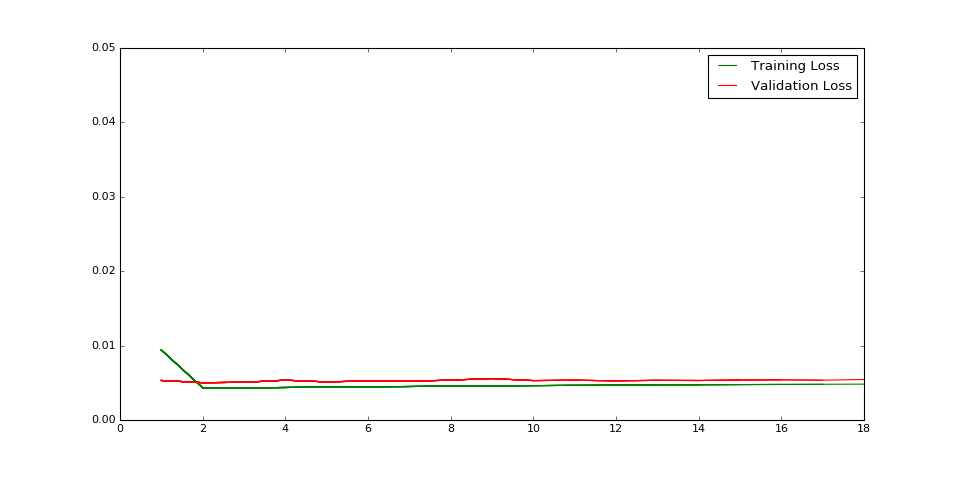

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0094

2017-04-10 17:08:38,262 : INFO : Found lower val loss for epoch 1 => 0.00531


1286325/1286325 [==============================] - 17s - loss: 0.0094 - val_loss: 0.0053
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 17:08:55,648 : INFO : Found lower val loss for epoch 2 => 0.00502


1286325/1286325 [==============================] - 17s - loss: 0.0043 - val_loss: 0.0050
Epoch 3/200
1286325/1286325 [==============================] - 17s - loss: 0.0043 - val_loss: 0.0051
Epoch 4/200
1286325/1286325 [==============================] - 17s - loss: 0.0044 - val_loss: 0.0054
Epoch 5/200
1286325/1286325 [==============================] - 17s - loss: 0.0044 - val_loss: 0.0051
Epoch 6/200
1286325/1286325 [==============================] - 17s - loss: 0.0045 - val_loss: 0.0053
Epoch 7/200
1286325/1286325 [==============================] - 17s - loss: 0.0045 - val_loss: 0.0052
Epoch 8/200
1286325/1286325 [==============================] - 17s - loss: 0.0045 - val_loss: 0.0054
Epoch 9/200
1286325/1286325 [==============================] - 17s - loss: 0.0046 - val_loss: 0.0056
Epoch 10/200
1286325/1286325 [==============================] - 17s - loss: 0.0046 - val_loss: 0.0053
Epoch 11/200
1286325/1286325 [==============================] - 17s - loss: 0.0047 - val_loss: 0.0053


2017-04-10 17:13:36,152 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00017: early stopping
CPU times: user 4min 15s, sys: 3min 5s, total: 7min 21s
Wall time: 5min 16s


2017-04-10 17:14:33,361 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 13.842 | Top 3: 0.671 | Top 5: 0.755 | F1 Micro: 0.428 | F1 Macro: 0.051


2017-04-10 17:17:06,263 : INFO : ***************************************************************************************
2017-04-10 17:17:06,266 : INFO : nn_1st-size_200_1st-act_tanh_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           200200      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_46 (Dropout)             (None, 200)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          402000      dropout_46[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


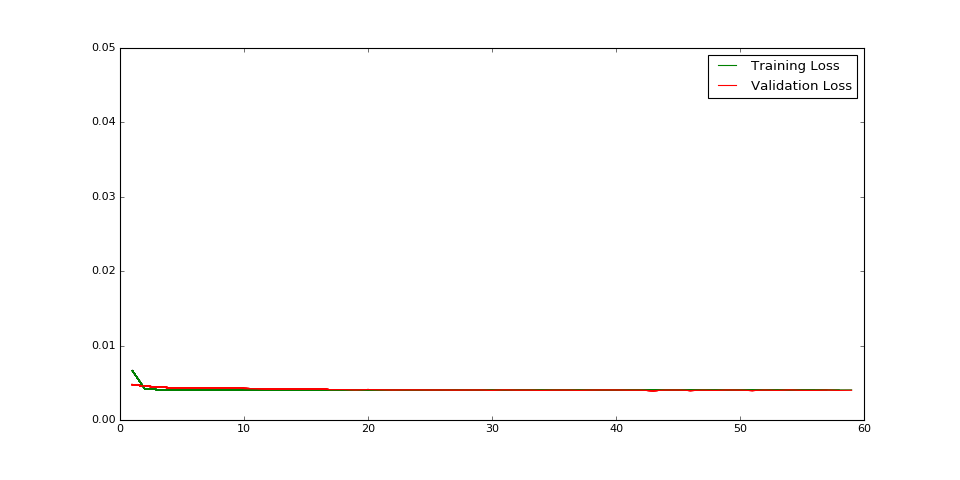

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0066

2017-04-10 17:17:28,831 : INFO : Found lower val loss for epoch 1 => 0.00476


1286325/1286325 [==============================] - 20s - loss: 0.0066 - val_loss: 0.0048
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:17:50,341 : INFO : Found lower val loss for epoch 2 => 0.00455


1286325/1286325 [==============================] - 21s - loss: 0.0042 - val_loss: 0.0045
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 17:18:11,607 : INFO : Found lower val loss for epoch 3 => 0.00444


1286325/1286325 [==============================] - 21s - loss: 0.0041 - val_loss: 0.0044
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 17:18:33,154 : INFO : Found lower val loss for epoch 4 => 0.00434


1286325/1286325 [==============================] - 21s - loss: 0.0041 - val_loss: 0.0043
Epoch 5/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0044
Epoch 6/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0044
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:19:36,923 : INFO : Found lower val loss for epoch 7 => 0.00428


1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0043
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:19:58,517 : INFO : Found lower val loss for epoch 8 => 0.00426


1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0043
Epoch 9/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0043
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:20:40,864 : INFO : Found lower val loss for epoch 10 => 0.00423


1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0042
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:21:01,170 : INFO : Found lower val loss for epoch 11 => 0.00422


1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0042
Epoch 12/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:21:21,483 : INFO : Found lower val loss for epoch 12 => 0.00412


1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0041
Epoch 13/200
1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0041
Epoch 14/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0041
Epoch 15/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0041
Epoch 16/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0041
Epoch 17/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:23:04,298 : INFO : Found lower val loss for epoch 17 => 0.00408


1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0041
Epoch 18/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0041
Epoch 19/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:23:45,839 : INFO : Found lower val loss for epoch 19 => 0.00402


1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0040
Epoch 20/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0041
Epoch 21/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 22/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:24:49,473 : INFO : Found lower val loss for epoch 22 => 0.00401


1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0040
Epoch 23/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 24/200
1286325/1286325 [==============================] - 22s - loss: 0.0040 - val_loss: 0.0040
Epoch 25/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 26/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0040
Epoch 27/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:26:38,013 : INFO : Found lower val loss for epoch 27 => 0.004


1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 28/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 29/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0040
Epoch 30/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:27:42,027 : INFO : Found lower val loss for epoch 30 => 0.00397


1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 31/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0040
Epoch 32/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 33/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 34/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:29:07,309 : INFO : Found lower val loss for epoch 34 => 0.00397


1286325/1286325 [==============================] - 22s - loss: 0.0040 - val_loss: 0.0040
Epoch 35/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0040
Epoch 36/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 37/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 38/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 39/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 40/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0040
Epoch 41/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 42/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 43/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 17:32:20,901 : INFO : Found lower val loss for epoch 43 => 0.00394


1286325/1286325 [==============================] - 22s - loss: 0.0040 - val_loss: 0.0039
Epoch 44/200
1286325/1286325 [==============================] - 22s - loss: 0.0040 - val_loss: 0.0040
Epoch 45/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 46/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 47/200
1286325/1286325 [==============================] - 22s - loss: 0.0040 - val_loss: 0.0040
Epoch 48/200
1286325/1286325 [==============================] - 22s - loss: 0.0040 - val_loss: 0.0040
Epoch 49/200
1286325/1286325 [==============================] - 22s - loss: 0.0040 - val_loss: 0.0040
Epoch 50/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 51/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 52/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 

2017-04-10 17:38:08,940 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00058: early stopping
CPU times: user 14min 33s, sys: 13min 52s, total: 28min 25s
Wall time: 21min 2s


2017-04-10 17:39:09,874 : INFO : Generating Validation Metrics
2017-04-10 17:41:45,684 : INFO : ***************************************************************************************


****** Validation Metrics: Cov Err: 10.822 | Top 3: 0.673 | Top 5: 0.755 | F1 Micro: 0.478 | F1 Macro: 0.071


2017-04-10 17:41:45,686 : INFO : nn_1st-size_100_1st-act_tanh_2nd-size_1000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 100)           100100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_47 (Dropout)             (None, 100)           0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 1000)          101000      dropout_47[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


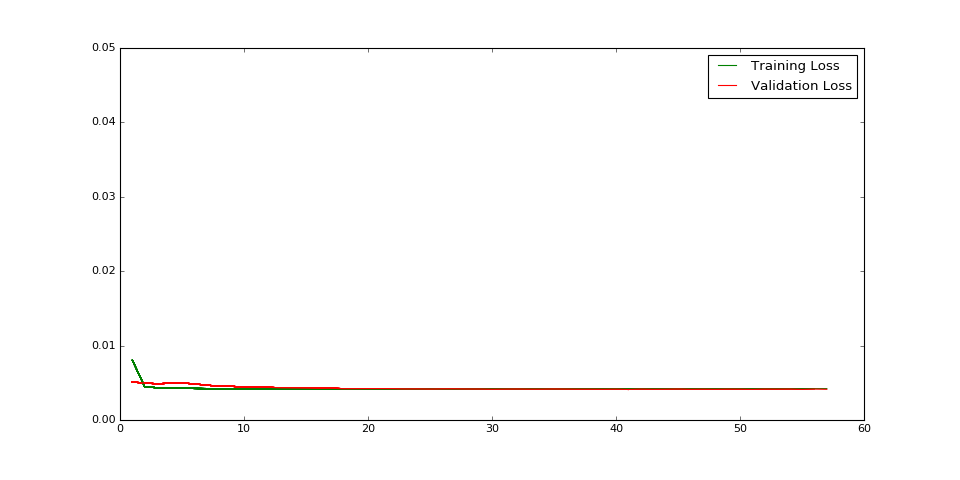

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0080

2017-04-10 17:42:04,929 : INFO : Found lower val loss for epoch 1 => 0.00511


1286325/1286325 [==============================] - 17s - loss: 0.0080 - val_loss: 0.0051
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0045

2017-04-10 17:42:22,579 : INFO : Found lower val loss for epoch 2 => 0.00496


1286325/1286325 [==============================] - 17s - loss: 0.0045 - val_loss: 0.0050
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 17:42:40,685 : INFO : Found lower val loss for epoch 3 => 0.00487


1286325/1286325 [==============================] - 18s - loss: 0.0043 - val_loss: 0.0049
Epoch 4/200
1286325/1286325 [==============================] - 18s - loss: 0.0043 - val_loss: 0.0049
Epoch 5/200
1286325/1286325 [==============================] - 18s - loss: 0.0043 - val_loss: 0.0050
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:43:35,444 : INFO : Found lower val loss for epoch 6 => 0.00485


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0048
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:43:53,127 : INFO : Found lower val loss for epoch 7 => 0.00468


1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0047
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:44:11,594 : INFO : Found lower val loss for epoch 8 => 0.00454


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0045
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:44:29,545 : INFO : Found lower val loss for epoch 9 => 0.00453


1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0045
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:44:47,323 : INFO : Found lower val loss for epoch 10 => 0.00443


1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0044
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:45:05,206 : INFO : Found lower val loss for epoch 11 => 0.00441


1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0044
Epoch 12/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:45:24,028 : INFO : Found lower val loss for epoch 12 => 0.00438


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0044
Epoch 13/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:45:43,169 : INFO : Found lower val loss for epoch 13 => 0.00434


1286325/1286325 [==============================] - 19s - loss: 0.0042 - val_loss: 0.0043
Epoch 14/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:46:01,954 : INFO : Found lower val loss for epoch 14 => 0.00432


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0043
Epoch 15/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:46:20,040 : INFO : Found lower val loss for epoch 15 => 0.00429


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0043
Epoch 16/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:46:38,036 : INFO : Found lower val loss for epoch 16 => 0.00425


1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0042
Epoch 17/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0043
Epoch 18/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:47:15,149 : INFO : Found lower val loss for epoch 18 => 0.00422


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0042
Epoch 19/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0042
Epoch 20/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0042
Epoch 21/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0042
Epoch 22/200
1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0042
Epoch 23/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:48:45,056 : INFO : Found lower val loss for epoch 23 => 0.00418


1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0042
Epoch 24/200
1286325/1286325 [==============================] - 19s - loss: 0.0042 - val_loss: 0.0042
Epoch 25/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:49:22,403 : INFO : Found lower val loss for epoch 25 => 0.00416


1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0042
Epoch 26/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0042
Epoch 27/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0042
Epoch 28/200
1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0042
Epoch 29/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0042
Epoch 30/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:50:54,039 : INFO : Found lower val loss for epoch 30 => 0.00413


1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0041
Epoch 31/200
1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0042
Epoch 32/200
1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0042
Epoch 33/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0041
Epoch 34/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0041
Epoch 35/200
1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0042
Epoch 36/200
1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0042
Epoch 37/200
1286325/1286325 [==============================] - 16s - loss: 0.0042 - val_loss: 0.0041
Epoch 38/200
1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0041
Epoch 39/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:53:33,373 : INFO : Found lower val loss for epoch 39 => 0.00413


1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0041
Epoch 40/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0041
Epoch 41/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 17:54:10,334 : INFO : Found lower val loss for epoch 41 => 0.0041
2017-04-10 17:54:10,336 : INFO : Validation Loss Reduced 20 times
2017-04-10 17:54:10,337 : INFO : Evaluating on Validation Data
2017-04-10 17:55:08,185 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 11.377 | Top 3: 0.661 | Top 5: 0.744 | F1 Micro: 0.465 | F1 Macro: 0.060
1286325/1286325 [==============================] - 229s - loss: 0.0042 - val_loss: 0.0041
Epoch 42/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0042
Epoch 43/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0041
Epoch 44/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0041
Epoch 45/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0042
Epoch 46/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0041
Epoch 47/200
1286325/1286325 [==============================] - 19s - loss: 0.0042 - val_loss: 0.0041
Epoch 48/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0041
Epoch 49/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - va

2017-04-10 18:02:37,732 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00056: early stopping
CPU times: user 16min 13s, sys: 11min 47s, total: 28min 1s
Wall time: 20min 51s


2017-04-10 18:03:36,359 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 11.377 | Top 3: 0.661 | Top 5: 0.744 | F1 Micro: 0.465 | F1 Macro: 0.060


2017-04-10 18:06:10,869 : INFO : ***************************************************************************************
2017-04-10 18:06:10,871 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           500500      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_48 (Dropout)             (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          1002000     dropout_48[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


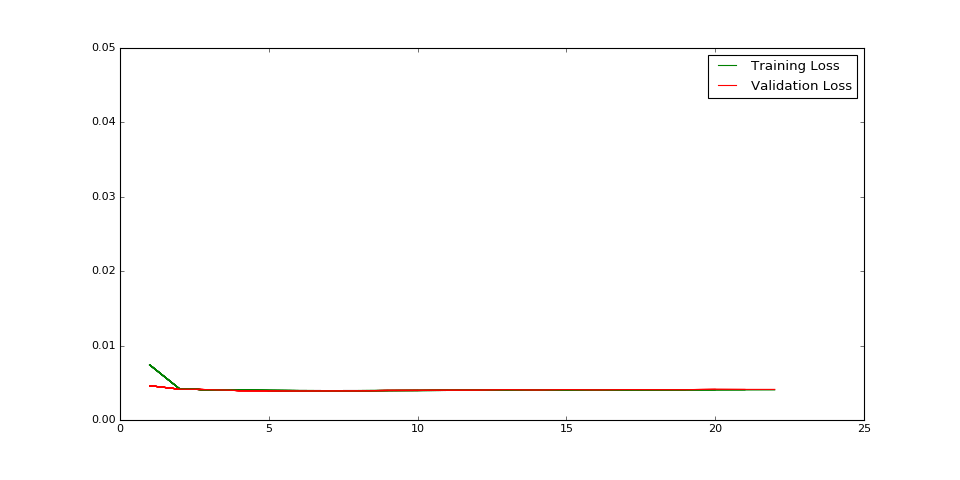

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0074

2017-04-10 18:06:35,524 : INFO : Found lower val loss for epoch 1 => 0.00461


1286325/1286325 [==============================] - 19s - loss: 0.0074 - val_loss: 0.0046
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 18:06:55,953 : INFO : Found lower val loss for epoch 2 => 0.00414


1286325/1286325 [==============================] - 20s - loss: 0.0042 - val_loss: 0.0041
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 18:07:15,235 : INFO : Found lower val loss for epoch 3 => 0.00408


1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0041
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 18:07:35,144 : INFO : Found lower val loss for epoch 4 => 0.00395


1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0040
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 18:07:54,237 : INFO : Found lower val loss for epoch 5 => 0.00395


1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0039
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 18:08:13,932 : INFO : Found lower val loss for epoch 6 => 0.00393


1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0039
Epoch 7/200
1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0039
Epoch 8/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0039
Epoch 9/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0040
Epoch 10/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0040
Epoch 11/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 12/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 13/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0041
Epoch 14/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0040
Epoch 15/200
1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0

2017-04-10 18:25:10,623 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00018: early stopping
CPU times: user 5min 5s, sys: 4min 17s, total: 9min 22s
Wall time: 7min 40s


2017-04-10 18:26:08,558 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.920 | Top 3: 0.674 | Top 5: 0.759 | F1 Micro: 0.466 | F1 Macro: 0.084


2017-04-10 18:28:41,977 : INFO : ***************************************************************************************
2017-04-10 18:28:41,979 : INFO : nn_1st-size_200_1st-act_sigmoid_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200)           200200      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_50 (Dropout)             (None, 200)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          201000      dropout_50[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


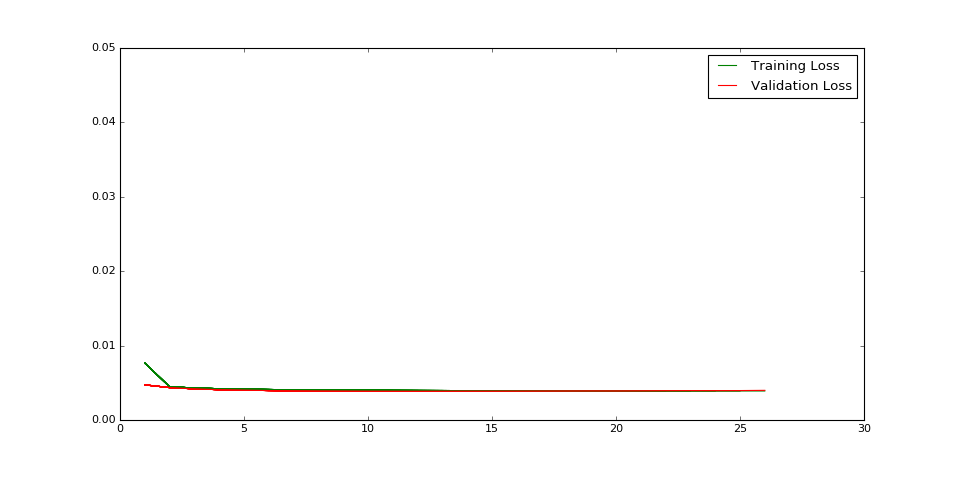

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0077

2017-04-10 18:29:00,699 : INFO : Found lower val loss for epoch 1 => 0.00472


1286325/1286325 [==============================] - 16s - loss: 0.0076 - val_loss: 0.0047
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0045

2017-04-10 18:29:17,902 : INFO : Found lower val loss for epoch 2 => 0.00436


1286325/1286325 [==============================] - 17s - loss: 0.0045 - val_loss: 0.0044
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 18:29:35,009 : INFO : Found lower val loss for epoch 3 => 0.00419


1286325/1286325 [==============================] - 17s - loss: 0.0043 - val_loss: 0.0042
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 18:29:51,909 : INFO : Found lower val loss for epoch 4 => 0.00408


1286325/1286325 [==============================] - 16s - loss: 0.0042 - val_loss: 0.0041
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 18:30:08,428 : INFO : Found lower val loss for epoch 5 => 0.00401


1286325/1286325 [==============================] - 16s - loss: 0.0041 - val_loss: 0.0040
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 18:30:25,878 : INFO : Found lower val loss for epoch 6 => 0.00396


1286325/1286325 [==============================] - 17s - loss: 0.0041 - val_loss: 0.0040
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 18:30:43,993 : INFO : Found lower val loss for epoch 7 => 0.00392


1286325/1286325 [==============================] - 18s - loss: 0.0041 - val_loss: 0.0039
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 18:31:01,962 : INFO : Found lower val loss for epoch 8 => 0.00389


1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0039
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 18:31:19,473 : INFO : Found lower val loss for epoch 9 => 0.00388


1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0039
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 18:31:36,864 : INFO : Found lower val loss for epoch 10 => 0.00387


1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0039
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 18:31:53,634 : INFO : Found lower val loss for epoch 11 => 0.00387


1286325/1286325 [==============================] - 16s - loss: 0.0040 - val_loss: 0.0039
Epoch 12/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 18:32:10,934 : INFO : Found lower val loss for epoch 12 => 0.00387


1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0039
Epoch 13/200
1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0039
Epoch 14/200
1286325/1286325 [==============================] - 17s - loss: 0.0040 - val_loss: 0.0039
Epoch 15/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0039
Epoch 16/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0039
Epoch 17/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0039
Epoch 18/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0039
Epoch 19/200
1286325/1286325 [==============================] - 17s - loss: 0.0039 - val_loss: 0.0039
Epoch 20/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 0.0039
Epoch 21/200
1286325/1286325 [==============================] - 16s - loss: 0.0039 - val_loss: 

2017-04-10 18:36:12,405 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00025: early stopping
CPU times: user 5min 52s, sys: 4min 40s, total: 10min 32s
Wall time: 7min 30s


2017-04-10 18:37:14,994 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 10.176 | Top 3: 0.676 | Top 5: 0.760 | F1 Micro: 0.472 | F1 Macro: 0.061


2017-04-10 18:39:50,269 : INFO : ***************************************************************************************
2017-04-10 18:39:50,272 : INFO : nn_1st-size_100_1st-act_sigmoid_2nd-size_2000_2nd-act_relu_in-drop_False_hid-drop_True


skipping: nn_1st-size_100_1st-act_sigmoid_2nd-size_1000_2nd-act_tanh_in-drop_False_hid-drop_True
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 100)           100100      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_51 (Dropout)             (None, 100)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 2000)          202000      dropout_51[0][0]            

<IPython.core.display.Javascript object>


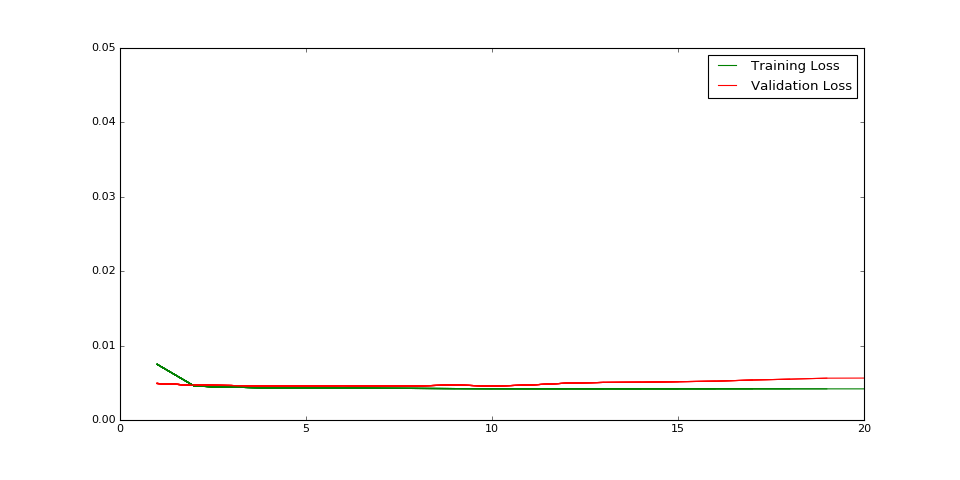

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0075

2017-04-10 18:40:09,506 : INFO : Found lower val loss for epoch 1 => 0.00491


1286325/1286325 [==============================] - 17s - loss: 0.0075 - val_loss: 0.0049
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0046

2017-04-10 18:40:26,299 : INFO : Found lower val loss for epoch 2 => 0.00467


1286325/1286325 [==============================] - 16s - loss: 0.0046 - val_loss: 0.0047
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0044

2017-04-10 18:40:43,138 : INFO : Found lower val loss for epoch 3 => 0.00463


1286325/1286325 [==============================] - 16s - loss: 0.0044 - val_loss: 0.0046
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 18:41:00,255 : INFO : Found lower val loss for epoch 4 => 0.00453


1286325/1286325 [==============================] - 17s - loss: 0.0043 - val_loss: 0.0045
Epoch 5/200
1286325/1286325 [==============================] - 16s - loss: 0.0043 - val_loss: 0.0046
Epoch 6/200
1286325/1286325 [==============================] - 16s - loss: 0.0043 - val_loss: 0.0046
Epoch 7/200
1286325/1286325 [==============================] - 18s - loss: 0.0043 - val_loss: 0.0045
Epoch 8/200
1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0046
Epoch 9/200
1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0047
Epoch 10/200
1286325/1286325 [==============================] - 16s - loss: 0.0042 - val_loss: 0.0046
Epoch 11/200
1286325/1286325 [==============================] - 17s - loss: 0.0042 - val_loss: 0.0047
Epoch 12/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.0049
Epoch 13/200
1286325/1286325 [==============================] - 18s - loss: 0.0042 - val_loss: 0.005

2017-04-10 18:45:47,302 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00019: early stopping
CPU times: user 4min 42s, sys: 3min 29s, total: 8min 12s
Wall time: 5min 56s


2017-04-10 18:46:48,142 : INFO : Generating Validation Metrics
2017-04-10 18:49:23,594 : INFO : ***************************************************************************************


****** Validation Metrics: Cov Err: 11.919 | Top 3: 0.648 | Top 5: 0.733 | F1 Micro: 0.435 | F1 Macro: 0.048


2017-04-10 18:49:23,598 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           500500      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_52 (Dropout)             (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           250500      dropout_52[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


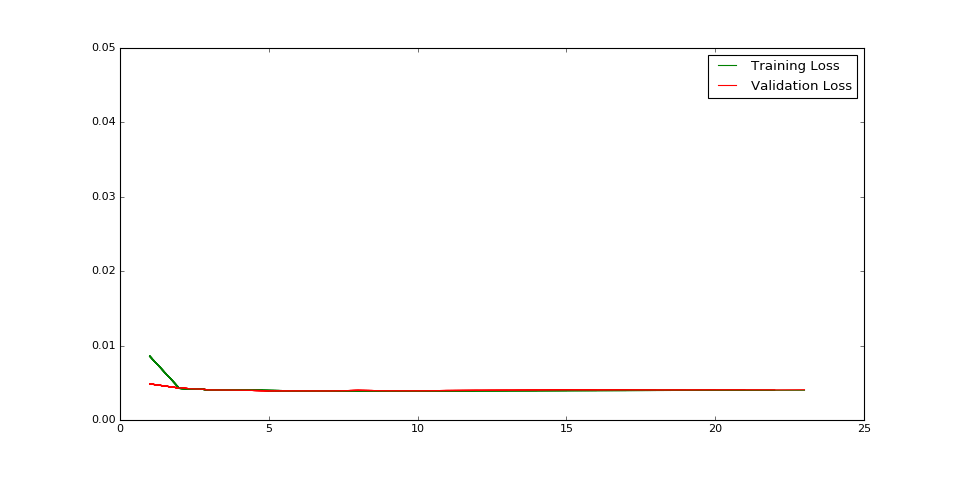

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0086

2017-04-10 18:49:44,983 : INFO : Found lower val loss for epoch 1 => 0.00485


1286325/1286325 [==============================] - 19s - loss: 0.0086 - val_loss: 0.0049
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 18:50:05,137 : INFO : Found lower val loss for epoch 2 => 0.00429


1286325/1286325 [==============================] - 20s - loss: 0.0042 - val_loss: 0.0043
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 18:50:25,704 : INFO : Found lower val loss for epoch 3 => 0.00407


1286325/1286325 [==============================] - 20s - loss: 0.0041 - val_loss: 0.0041
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 18:50:45,763 : INFO : Found lower val loss for epoch 4 => 0.00399


1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0040
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 18:51:06,889 : INFO : Found lower val loss for epoch 5 => 0.00395


1286325/1286325 [==============================] - 21s - loss: 0.0040 - val_loss: 0.0039
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 18:51:27,921 : INFO : Found lower val loss for epoch 6 => 0.00394


1286325/1286325 [==============================] - 21s - loss: 0.0039 - val_loss: 0.0039
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 18:51:48,403 : INFO : Found lower val loss for epoch 7 => 0.00393


1286325/1286325 [==============================] - 20s - loss: 0.0039 - val_loss: 0.0039
Epoch 8/200
1286325/1286325 [==============================] - 21s - loss: 0.0039 - val_loss: 0.0040
Epoch 9/200
1286325/1286325 [==============================] - 20s - loss: 0.0039 - val_loss: 0.0039
Epoch 10/200
1286325/1286325 [==============================] - 20s - loss: 0.0039 - val_loss: 0.0039
Epoch 11/200
1286325/1286325 [==============================] - 20s - loss: 0.0039 - val_loss: 0.0040
Epoch 12/200
1286325/1286325 [==============================] - 21s - loss: 0.0039 - val_loss: 0.0040
Epoch 13/200
1286325/1286325 [==============================] - 20s - loss: 0.0039 - val_loss: 0.0040
Epoch 14/200
1286325/1286325 [==============================] - 20s - loss: 0.0039 - val_loss: 0.0040
Epoch 15/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0040
Epoch 16/200
1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.

2017-04-10 18:57:18,569 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00022: early stopping
CPU times: user 5min 25s, sys: 5min 14s, total: 10min 40s
Wall time: 7min 54s


2017-04-10 18:58:16,137 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 10.583 | Top 3: 0.680 | Top 5: 0.762 | F1 Micro: 0.482 | F1 Macro: 0.078


2017-04-10 19:00:49,141 : INFO : ***************************************************************************************
2017-04-10 19:00:49,142 : INFO : nn_1st-size_500_1st-act_sigmoid_2nd-size_2000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 500)           500500      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_53 (Dropout)             (None, 500)           0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 2000)          1002000     dropout_53[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


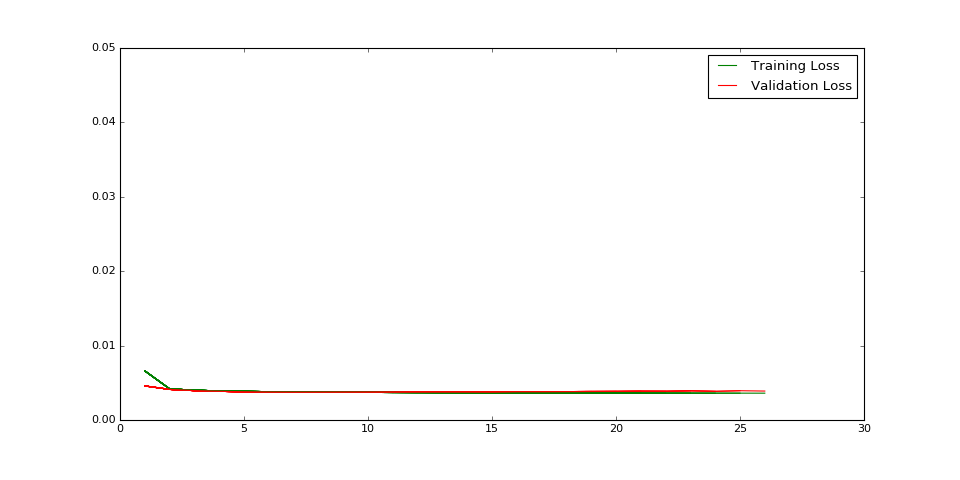

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0066

2017-04-10 19:01:10,291 : INFO : Found lower val loss for epoch 1 => 0.00458


1286325/1286325 [==============================] - 19s - loss: 0.0066 - val_loss: 0.0046
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 19:01:29,627 : INFO : Found lower val loss for epoch 2 => 0.00411


1286325/1286325 [==============================] - 19s - loss: 0.0042 - val_loss: 0.0041
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 19:01:48,645 : INFO : Found lower val loss for epoch 3 => 0.00395


1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0039
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 19:02:07,648 : INFO : Found lower val loss for epoch 4 => 0.00385


1286325/1286325 [==============================] - 19s - loss: 0.0039 - val_loss: 0.0039
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 19:02:26,778 : INFO : Found lower val loss for epoch 5 => 0.00379


1286325/1286325 [==============================] - 19s - loss: 0.0039 - val_loss: 0.0038
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-10 19:02:47,392 : INFO : Found lower val loss for epoch 6 => 0.00375


1286325/1286325 [==============================] - 20s - loss: 0.0038 - val_loss: 0.0038
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-10 19:03:09,466 : INFO : Found lower val loss for epoch 7 => 0.00373


1286325/1286325 [==============================] - 22s - loss: 0.0038 - val_loss: 0.0037
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-10 19:03:31,079 : INFO : Found lower val loss for epoch 8 => 0.00372


1286325/1286325 [==============================] - 21s - loss: 0.0037 - val_loss: 0.0037
Epoch 9/200
1286325/1286325 [==============================] - 21s - loss: 0.0037 - val_loss: 0.0037
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-10 19:04:14,374 : INFO : Found lower val loss for epoch 10 => 0.00372


1286325/1286325 [==============================] - 21s - loss: 0.0037 - val_loss: 0.0037
Epoch 11/200
1286325/1286325 [==============================] - 21s - loss: 0.0037 - val_loss: 0.0037
Epoch 12/200
1286325/1286325 [==============================] - 22s - loss: 0.0037 - val_loss: 0.0037
Epoch 13/200
1286325/1286325 [==============================] - 22s - loss: 0.0037 - val_loss: 0.0037
Epoch 14/200
1286325/1286325 [==============================] - 22s - loss: 0.0037 - val_loss: 0.0038
Epoch 15/200
1286325/1286325 [==============================] - 22s - loss: 0.0037 - val_loss: 0.0037
Epoch 16/200
1286325/1286325 [==============================] - 22s - loss: 0.0036 - val_loss: 0.0038
Epoch 17/200
1286325/1286325 [==============================] - 22s - loss: 0.0036 - val_loss: 0.0038
Epoch 18/200
1286325/1286325 [==============================] - 21s - loss: 0.0036 - val_loss: 0.0038
Epoch 19/200
1286325/1286325 [==============================] - 22s - loss: 0.0036 - val_loss: 

2017-04-10 19:10:14,277 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00025: early stopping
CPU times: user 6min 30s, sys: 5min 36s, total: 12min 7s
Wall time: 9min 24s


2017-04-10 19:11:12,357 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.343 | Top 3: 0.693 | Top 5: 0.776 | F1 Micro: 0.458 | F1 Macro: 0.069


2017-04-10 19:13:45,679 : INFO : ***************************************************************************************
2017-04-10 19:13:45,681 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_1000_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          1001000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_54 (Dropout)             (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 1000)          1001000     dropout_54[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


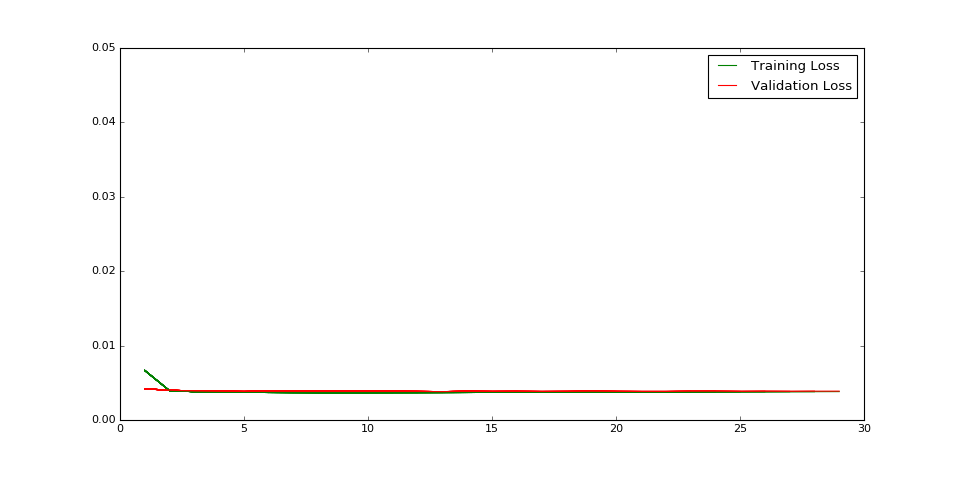

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0067

2017-04-10 19:14:06,571 : INFO : Found lower val loss for epoch 1 => 0.00419


1286325/1286325 [==============================] - 19s - loss: 0.0067 - val_loss: 0.0042
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 19:14:24,923 : INFO : Found lower val loss for epoch 2 => 0.004


1286325/1286325 [==============================] - 18s - loss: 0.0039 - val_loss: 0.0040
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-10 19:14:43,710 : INFO : Found lower val loss for epoch 3 => 0.0039


1286325/1286325 [==============================] - 18s - loss: 0.0038 - val_loss: 0.0039
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-10 19:15:02,365 : INFO : Found lower val loss for epoch 4 => 0.00386


1286325/1286325 [==============================] - 18s - loss: 0.0038 - val_loss: 0.0039
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-10 19:15:20,588 : INFO : Found lower val loss for epoch 5 => 0.00383


1286325/1286325 [==============================] - 18s - loss: 0.0037 - val_loss: 0.0038
Epoch 6/200
1286325/1286325 [==============================] - 18s - loss: 0.0037 - val_loss: 0.0039
Epoch 7/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0039
Epoch 8/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0039
Epoch 9/200
1286325/1286325 [==============================] - 19s - loss: 0.0037 - val_loss: 0.0039
Epoch 10/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0039
Epoch 11/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0039
Epoch 12/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0038
Epoch 13/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-10 19:18:01,366 : INFO : Found lower val loss for epoch 13 => 0.00381


1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0038
Epoch 14/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0039
Epoch 15/200
1286325/1286325 [==============================] - 21s - loss: 0.0037 - val_loss: 0.0038
Epoch 16/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0039
Epoch 17/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0038
Epoch 18/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0038
Epoch 19/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0039
Epoch 20/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0039
Epoch 21/200
1286325/1286325 [==============================] - 20s - loss: 0.0038 - val_loss: 0.0038
Epoch 22/200
1286325/1286325 [==============================] - 21s - loss: 0.0038 - val_loss: 

2017-04-10 19:23:35,003 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00028: early stopping
CPU times: user 7min 2s, sys: 5min 54s, total: 12min 57s
Wall time: 9min 49s


2017-04-10 19:24:32,346 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.492 | Top 3: 0.691 | Top 5: 0.774 | F1 Micro: 0.503 | F1 Macro: 0.106


2017-04-10 19:27:05,961 : INFO : ***************************************************************************************
2017-04-10 19:27:05,964 : INFO : nn_1st-size_1000_1st-act_sigmoid_2nd-size_500_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 1000)          1001000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_55 (Dropout)             (None, 1000)          0           hidden_layer_sigmoid[0][0]       
____________________________________________________________________________________________________
hidden_layer2_relu (Dense)       (None, 500)           500500      dropout_55[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


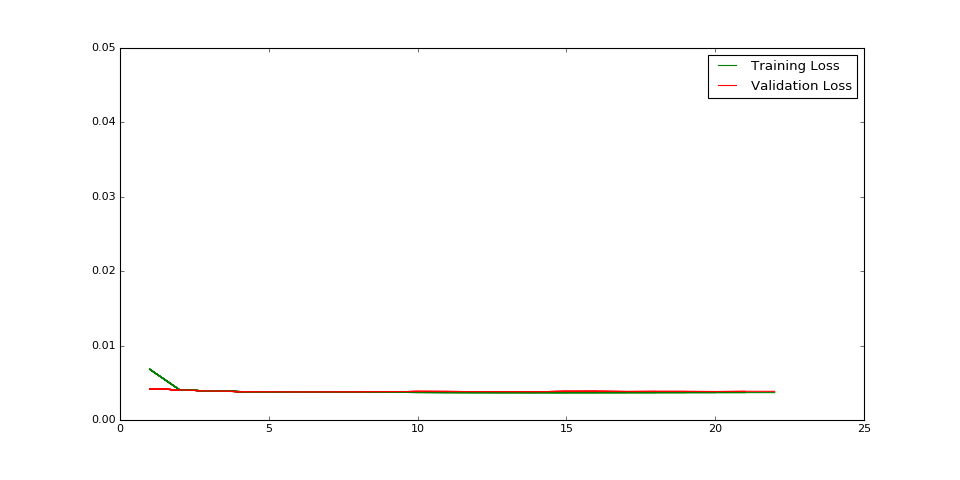

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0068

2017-04-10 19:27:27,018 : INFO : Found lower val loss for epoch 1 => 0.00421


1286325/1286325 [==============================] - 19s - loss: 0.0068 - val_loss: 0.0042
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 19:27:47,418 : INFO : Found lower val loss for epoch 2 => 0.00405


1286325/1286325 [==============================] - 20s - loss: 0.0041 - val_loss: 0.0040
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 19:28:07,659 : INFO : Found lower val loss for epoch 3 => 0.0039


1286325/1286325 [==============================] - 20s - loss: 0.0039 - val_loss: 0.0039
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-10 19:28:28,912 : INFO : Found lower val loss for epoch 4 => 0.00382


1286325/1286325 [==============================] - 21s - loss: 0.0038 - val_loss: 0.0038
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-10 19:28:49,041 : INFO : Found lower val loss for epoch 5 => 0.0038


1286325/1286325 [==============================] - 20s - loss: 0.0038 - val_loss: 0.0038
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-10 19:29:09,683 : INFO : Found lower val loss for epoch 6 => 0.00377


1286325/1286325 [==============================] - 20s - loss: 0.0038 - val_loss: 0.0038
Epoch 7/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0038
Epoch 8/200
1286325/1286325 [==============================] - 21s - loss: 0.0037 - val_loss: 0.0038
Epoch 9/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0038
Epoch 10/200
1286325/1286325 [==============================] - 21s - loss: 0.0037 - val_loss: 0.0038
Epoch 11/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0038
Epoch 12/200
1286325/1286325 [==============================] - 21s - loss: 0.0037 - val_loss: 0.0038
Epoch 13/200
1286325/1286325 [==============================] - 21s - loss: 0.0037 - val_loss: 0.0038
Epoch 14/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0038
Epoch 15/200
1286325/1286325 [==============================] - 20s - loss: 0.0037 - val_loss: 0.0

2017-04-10 19:34:43,747 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00021: early stopping
CPU times: user 5min 23s, sys: 4min 58s, total: 10min 22s
Wall time: 7min 37s


2017-04-10 19:35:43,942 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.707 | Top 3: 0.693 | Top 5: 0.775 | F1 Micro: 0.486 | F1 Macro: 0.079


2017-04-10 19:38:19,554 : INFO : ***************************************************************************************
2017-04-10 19:38:19,559 : INFO : nn_1st-size_1000_1st-act_relu_2nd-size_None_2nd-act_relu_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 1000)          1001000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_56 (Dropout)             (None, 1000)          0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 940)           940940      dropout_56[0][0]                 
Total params: 1941940
_____________________________________________________________________

<IPython.core.display.Javascript object>


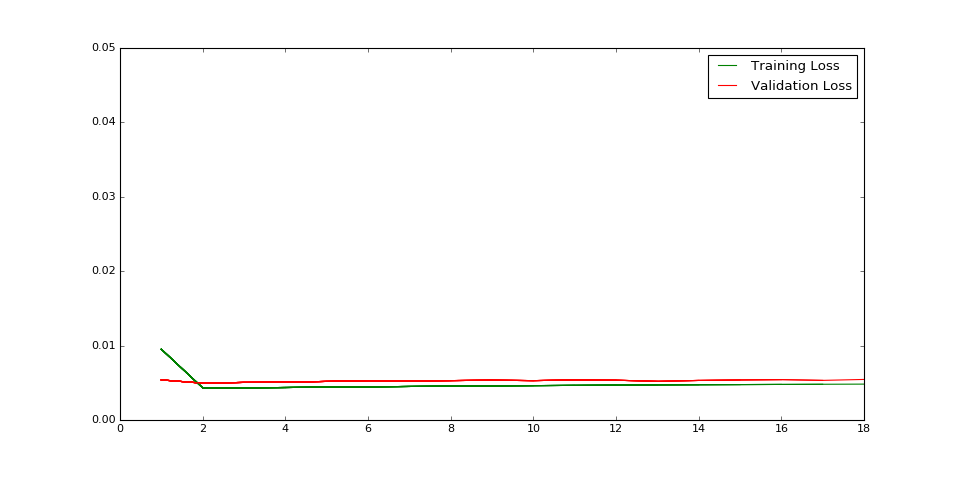

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0095

2017-04-10 19:38:39,035 : INFO : Found lower val loss for epoch 1 => 0.00539


1286325/1286325 [==============================] - 18s - loss: 0.0095 - val_loss: 0.0054
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0043

2017-04-10 19:38:56,388 : INFO : Found lower val loss for epoch 2 => 0.00495


1286325/1286325 [==============================] - 17s - loss: 0.0043 - val_loss: 0.0049
Epoch 3/200
1286325/1286325 [==============================] - 17s - loss: 0.0043 - val_loss: 0.0051
Epoch 4/200
1286325/1286325 [==============================] - 16s - loss: 0.0044 - val_loss: 0.0051
Epoch 5/200
1286325/1286325 [==============================] - 16s - loss: 0.0044 - val_loss: 0.0052
Epoch 6/200
1286325/1286325 [==============================] - 17s - loss: 0.0045 - val_loss: 0.0053
Epoch 7/200
1286325/1286325 [==============================] - 16s - loss: 0.0045 - val_loss: 0.0052
Epoch 8/200
1286325/1286325 [==============================] - 17s - loss: 0.0045 - val_loss: 0.0053
Epoch 9/200
1286325/1286325 [==============================] - 17s - loss: 0.0046 - val_loss: 0.0054
Epoch 10/200
1286325/1286325 [==============================] - 16s - loss: 0.0046 - val_loss: 0.0053
Epoch 11/200
1286325/1286325 [==============================] - 16s - loss: 0.0047 - val_loss: 0.0054


2017-04-10 19:43:30,403 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00017: early stopping
CPU times: user 4min 6s, sys: 3min 13s, total: 7min 19s
Wall time: 5min 10s


2017-04-10 19:44:33,374 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 13.823 | Top 3: 0.672 | Top 5: 0.755 | F1 Micro: 0.427 | F1 Macro: 0.052


2017-04-10 19:47:00,899 : INFO : ***************************************************************************************
2017-04-10 19:47:00,901 : INFO : nn_1st-size_1000_1st-act_tanh_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 1000)          1001000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_57 (Dropout)             (None, 1000)          0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 500)           500500      dropout_57[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


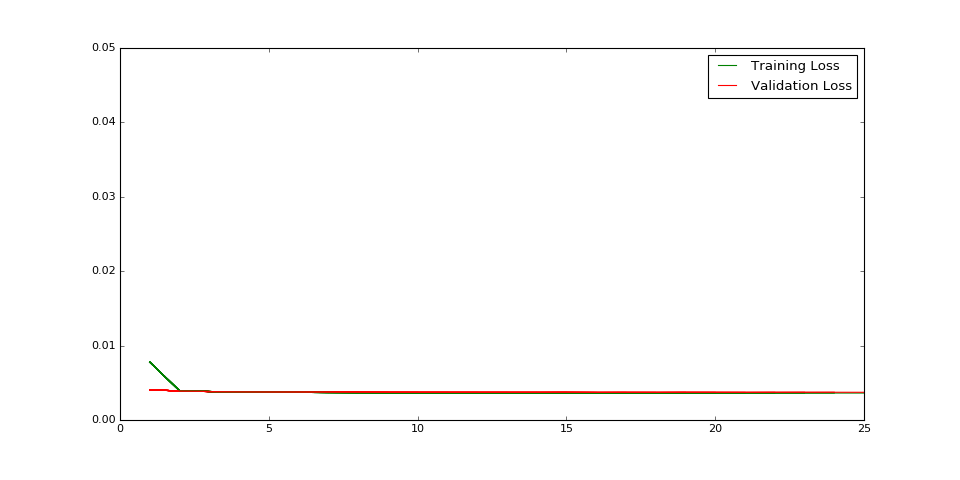

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0078

2017-04-10 19:47:20,788 : INFO : Found lower val loss for epoch 1 => 0.00408


1286325/1286325 [==============================] - 18s - loss: 0.0078 - val_loss: 0.0041
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 19:47:39,229 : INFO : Found lower val loss for epoch 2 => 0.00389


1286325/1286325 [==============================] - 18s - loss: 0.0039 - val_loss: 0.0039
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-10 19:47:57,185 : INFO : Found lower val loss for epoch 3 => 0.00383


1286325/1286325 [==============================] - 17s - loss: 0.0038 - val_loss: 0.0038
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0038

2017-04-10 19:48:15,953 : INFO : Found lower val loss for epoch 4 => 0.00378


1286325/1286325 [==============================] - 18s - loss: 0.0038 - val_loss: 0.0038
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-10 19:48:34,494 : INFO : Found lower val loss for epoch 5 => 0.00375


1286325/1286325 [==============================] - 18s - loss: 0.0037 - val_loss: 0.0038
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-10 19:48:53,584 : INFO : Found lower val loss for epoch 6 => 0.00374


1286325/1286325 [==============================] - 19s - loss: 0.0037 - val_loss: 0.0037
Epoch 7/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-10 19:49:11,914 : INFO : Found lower val loss for epoch 7 => 0.00373


1286325/1286325 [==============================] - 18s - loss: 0.0037 - val_loss: 0.0037
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-10 19:49:30,472 : INFO : Found lower val loss for epoch 8 => 0.00372


1286325/1286325 [==============================] - 18s - loss: 0.0037 - val_loss: 0.0037
Epoch 9/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-10 19:49:49,069 : INFO : Found lower val loss for epoch 9 => 0.00371


1286325/1286325 [==============================] - 18s - loss: 0.0037 - val_loss: 0.0037
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-10 19:50:07,250 : INFO : Found lower val loss for epoch 10 => 0.00371


1286325/1286325 [==============================] - 18s - loss: 0.0037 - val_loss: 0.0037
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0037

2017-04-10 19:50:24,753 : INFO : Found lower val loss for epoch 11 => 0.00371


1286325/1286325 [==============================] - 17s - loss: 0.0037 - val_loss: 0.0037
Epoch 12/200
1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0037
Epoch 13/200
1286325/1286325 [==============================] - 18s - loss: 0.0036 - val_loss: 0.0037
Epoch 14/200
1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0037
Epoch 15/200
1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0037
Epoch 16/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0036

2017-04-10 19:51:55,155 : INFO : Found lower val loss for epoch 16 => 0.0037


1286325/1286325 [==============================] - 18s - loss: 0.0036 - val_loss: 0.0037
Epoch 17/200
1286325/1286325 [==============================] - 18s - loss: 0.0036 - val_loss: 0.0037
Epoch 18/200
1286325/1286325 [==============================] - 18s - loss: 0.0036 - val_loss: 0.0037
Epoch 19/200
1286325/1286325 [==============================] - 18s - loss: 0.0036 - val_loss: 0.0037
Epoch 20/200
1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0037
Epoch 21/200
1286325/1286325 [==============================] - 18s - loss: 0.0036 - val_loss: 0.0037
Epoch 22/200
1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0037
Epoch 23/200
1286325/1286325 [==============================] - 17s - loss: 0.0036 - val_loss: 0.0037
Epoch 24/200
1286325/1286325 [==============================] - 18s - loss: 0.0036 - val_loss: 0.0037
Epoch 25/200
1286325/1286325 [==============================] - 18s - loss: 0.0036 - val_loss: 

2017-04-10 19:54:38,939 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00024: early stopping
CPU times: user 5min 42s, sys: 4min 47s, total: 10min 30s
Wall time: 7min 37s


2017-04-10 19:55:36,521 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 9.452 | Top 3: 0.697 | Top 5: 0.779 | F1 Micro: 0.508 | F1 Macro: 0.100


2017-04-10 19:58:08,860 : INFO : ***************************************************************************************
2017-04-10 19:58:08,863 : INFO : nn_1st-size_500_1st-act_relu_2nd-size_2000_2nd-act_tanh_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_relu (Dense)        (None, 500)           500500      doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_58 (Dropout)             (None, 500)           0           hidden_layer_relu[0][0]          
____________________________________________________________________________________________________
hidden_layer2_tanh (Dense)       (None, 2000)          1002000     dropout_58[0][0]                 
___________________________________________________________________________________________

<IPython.core.display.Javascript object>


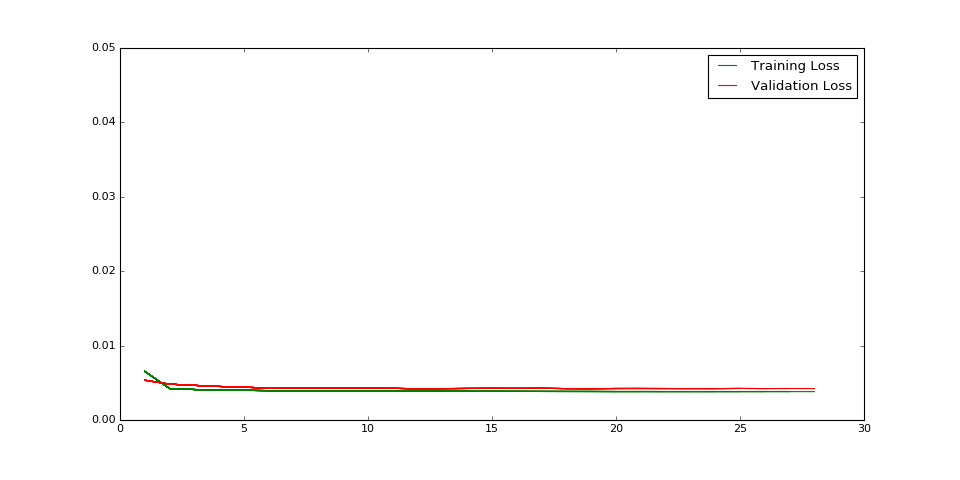

Epoch 1/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0065

2017-04-10 19:58:30,400 : INFO : Found lower val loss for epoch 1 => 0.00534


1286325/1286325 [==============================] - 19s - loss: 0.0065 - val_loss: 0.0053
Epoch 2/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0042

2017-04-10 19:58:49,505 : INFO : Found lower val loss for epoch 2 => 0.00482


1286325/1286325 [==============================] - 19s - loss: 0.0042 - val_loss: 0.0048
Epoch 3/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0041

2017-04-10 19:59:08,207 : INFO : Found lower val loss for epoch 3 => 0.00465


1286325/1286325 [==============================] - 18s - loss: 0.0041 - val_loss: 0.0047
Epoch 4/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 19:59:27,009 : INFO : Found lower val loss for epoch 4 => 0.00451


1286325/1286325 [==============================] - 18s - loss: 0.0040 - val_loss: 0.0045
Epoch 5/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 19:59:46,120 : INFO : Found lower val loss for epoch 5 => 0.0044


1286325/1286325 [==============================] - 19s - loss: 0.0040 - val_loss: 0.0044
Epoch 6/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0040

2017-04-10 20:00:06,402 : INFO : Found lower val loss for epoch 6 => 0.00431


1286325/1286325 [==============================] - 20s - loss: 0.0040 - val_loss: 0.0043
Epoch 7/200
1286325/1286325 [==============================] - 20s - loss: 0.0039 - val_loss: 0.0043
Epoch 8/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 20:00:48,817 : INFO : Found lower val loss for epoch 8 => 0.00428


1286325/1286325 [==============================] - 21s - loss: 0.0039 - val_loss: 0.0043
Epoch 9/200
1286325/1286325 [==============================] - 21s - loss: 0.0039 - val_loss: 0.0043
Epoch 10/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 20:01:31,724 : INFO : Found lower val loss for epoch 10 => 0.00426


1286325/1286325 [==============================] - 21s - loss: 0.0039 - val_loss: 0.0043
Epoch 11/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 20:01:53,179 : INFO : Found lower val loss for epoch 11 => 0.00425


1286325/1286325 [==============================] - 21s - loss: 0.0039 - val_loss: 0.0043
Epoch 12/200
1286144/1286325 [============================>.] - ETA: 0s - loss: 0.0039

2017-04-10 20:02:14,943 : INFO : Found lower val loss for epoch 12 => 0.0042


1286325/1286325 [==============================] - 21s - loss: 0.0039 - val_loss: 0.0042
Epoch 13/200
1286325/1286325 [==============================] - 21s - loss: 0.0039 - val_loss: 0.0042
Epoch 14/200
1286325/1286325 [==============================] - 21s - loss: 0.0039 - val_loss: 0.0042
Epoch 15/200
1286325/1286325 [==============================] - 21s - loss: 0.0038 - val_loss: 0.0043
Epoch 16/200
1286325/1286325 [==============================] - 22s - loss: 0.0038 - val_loss: 0.0042
Epoch 17/200
1286325/1286325 [==============================] - 21s - loss: 0.0038 - val_loss: 0.0043
Epoch 18/200
1286325/1286325 [==============================] - 21s - loss: 0.0038 - val_loss: 0.0042
Epoch 19/200
1286325/1286325 [==============================] - 21s - loss: 0.0038 - val_loss: 0.0042
Epoch 20/200
1286325/1286325 [==============================] - 21s - loss: 0.0038 - val_loss: 0.0042
Epoch 21/200
1286325/1286325 [==============================] - 22s - loss: 0.0038 - val_loss: 

2017-04-10 20:08:05,707 : INFO : Evaluating on Validation Data using saved best weights



Epoch 00027: early stopping
CPU times: user 6min 48s, sys: 5min 57s, total: 12min 46s
Wall time: 9min 56s


2017-04-10 20:09:03,132 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 10.837 | Top 3: 0.650 | Top 5: 0.743 | F1 Micro: 0.471 | F1 Macro: 0.105
CPU times: user 3h 18min 20s, sys: 2h 4min 20s, total: 5h 22min 41s
Wall time: 4h 19min 34s


In [ ]:
%%time
ta_types = ["bm25"]
# data_types = ["tf"]
for data_type in data_types:
    info("=============== {} Being Evaluated ================".format(data_type))
    
    GLOBAL_VARS.MODEL_NAME = data_type + "/{}".format(LDA_MODEL_NAME)
     
    data_training_location = os.path.join(lda_location, LDA_MODEL_NAME, data_type, "lda_training_data.pkl")
    data_training_docids_location = exports_location + "{}_training_sparse_docids.pkl".format(data_type)
    data_validation_location = os.path.join(lda_location, LDA_MODEL_NAME, data_type, "lda_validation_data.pkl")
    data_validation_docids_location = exports_location + "{}_validation_sparse_docids.pkl".format(data_type)
    
    # Get the training data
    info('Getting Training Data')
#     %time X = pickle.load(open(data_training_location, "r"))
    training_data_docids = pickle.load(open(data_training_docids_location, "r"))
    %time y = get_label_data(classifications, training_data_docids, doc_classification_map)
    
    print X.shape
    print y.shape

    # Get the validation data
    info('Getting Validation Data')
#     %time Xv = pickle.load(open(data_validation_location,'r'))
    validation_data_docids = pickle.load(open(data_validation_docids_location, "r"))
    %time yv = get_label_data(classifications, validation_data_docids, doc_classification_map)
    
    NN_INPUT_NEURONS = X.shape[1]


    param_sampler = ParameterSampler({
        'first_hidden_layer_size':first_hidden_layer_sizes,
        'first_hidden_layer_activation':first_hidden_layer_activations,
        'second_hidden_layer_size':second_hidden_layer_sizes,
        'second_hidden_layer_activation':second_hidden_layer_activations,
        'input_dropout':input_dropout_options,
        'hidden_dropout':hidden_dropout_options,
        'second_hidden_dropout':second_hidden_dropout_options
    }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)

    param_results_dict = {}

    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))

    if load_existing_results:
        param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE)))
        if os.path.exists(param_results_path):
            info('Loading Previous results in {}'.format(param_results_path))
            param_results_dict = pickle.load(open(param_results_path))
        else:
            info('No Previous results exist in {}'.format(param_results_path))

    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

    for parameters in param_sampler:
        start_time = time.time()
        first_hidden_layer_size = parameters['first_hidden_layer_size']
        first_hidden_layer_activation = parameters['first_hidden_layer_activation']
        second_hidden_layer_size = parameters['second_hidden_layer_size']
        second_hidden_layer_activation = parameters['second_hidden_layer_activation']
        input_dropout_do = parameters['input_dropout']
        hidden_dropout_do = parameters['hidden_dropout']
        second_hidden_dropout_do = parameters['second_hidden_dropout']

        GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
            first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
            second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
        )
        if second_hidden_dropout_do:
            GLOBAL_VARS.NN_MODEL_NAME = GLOBAL_VARS.NN_MODEL_NAME + '_2nd-hid-drop_{}'.format(str(second_hidden_dropout_do))

        if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
            print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
            continue
    #         if first_hidden_layer_size < DOC2VEC_SIZE or second_hidden_layer_size < NN_OUTPUT_NEURONS:
    #             print "skipping: {} due to 1st layer size {} < {} or 2nd layer size {} < {}".format(GLOBAL_VARS.NN_MODEL_NAME,
    #                                                                                                 first_hidden_layer_size, DOC2VEC_SIZE, 
    #                                                                                                 second_hidden_layer_size, NN_OUTPUT_NEURONS)
    #             continue


        info('***************************************************************************************')
        info(GLOBAL_VARS.NN_MODEL_NAME)

        model = create_keras_nn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                                      first_hidden_layer_size, first_hidden_layer_activation, 
                                      second_hidden_layer_size, second_hidden_layer_activation, 
                                      input_dropout_do, hidden_dropout_do, second_hidden_dropout_do)
        model.summary()

        early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                      patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
        metrics_callback = MetricsCallbackWithGenerator()

        # Model Fitting
#         %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
#                                   nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, callbacks=[early_stopper, metrics_callback])

        %time history = model.fit_generator(generator=nn_batch_generator(X, y, NN_BATCH_SIZE), \
                                            samples_per_epoch=X.shape[0],\
                                            validation_data=nn_batch_generator(Xv, yv, NN_BATCH_SIZE),\
                                            nb_val_samples=Xv.shape[0],\
                                            nb_epoch=NN_MAX_EPOCHS, callbacks=[early_stopper, metrics_callback])

        # using the recorded weights of the best recorded validation loss
        last_model_weights = model.get_weights()
        info('Evaluating on Validation Data using saved best weights')
        model.set_weights(metrics_callback.best_weights)
        yvp = model.predict_generator(generator=nn_batch_generator(Xv, yv, NN_BATCH_SIZE), 
                                                   val_samples=Xv.shape[0])
        yvp_binary = get_binary_0_5(yvp)
        #print yvp
        info('Generating Validation Metrics')
        validation_metrics = get_metrics(yv, yvp, yvp_binary)
        print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
            validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
            validation_metrics['f1_micro'], validation_metrics['f1_macro'])
        best_validation_metrics = validation_metrics
        time.sleep(0.2)

        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

        duration = time.time() - start_time
        param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

        del history, last_model_weights, metrics_callback

    if save_results:
        if load_existing_results:
            if os.path.exists(param_results_path):
                info('Loading Previous results from {}'.format(param_results_path))
                loaded_param_results_dict = pickle.load(open(param_results_path))
                param_results_dict.update(loaded_param_results_dict)

        pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))
    #del X, Xv

In [26]:
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))


In [24]:
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))


## Testing

In [17]:
data_type = 'bm25'

In [39]:
classifications = valid_subclasses
classifications_type = 'subclasses'

In [40]:
LDA_TOPICS = 1000
LDA_ITERATIONS = 50
LDA_BATCH_SIZE = 4096
LDA_DECAY = 0.5
LDA_EVALUATE_EVERY = 1000
LDA_VERBOSE = 2
LDA_LEARNING_METHOD = 'online'
LDA_MODEL_NAME = "lda_{}_topics_{}_iter_{}_batch_{}_decay_{}_evaluate-every_{}".format(LDA_LEARNING_METHOD, 
                                                                                       LDA_TOPICS, LDA_ITERATIONS,
                                                                                       LDA_BATCH_SIZE, LDA_DECAY, 
                                                                                       LDA_EVALUATE_EVERY)

In [41]:
NN_BATCH_SIZE = 2048

In [42]:
data_test_location = os.path.join(lda_location, LDA_MODEL_NAME, data_type, "lda_test_data.pkl")
data_test_docids_location = exports_location + "{}_test_sparse_docids.pkl".format(data_type)

TEST_METRICS_FILENAME = '{}_batch_{}_test_metrics.pkl'.format(classifications_type, NN_BATCH_SIZE)
GLOBAL_VARS.MODEL_NAME = data_type + "/{}".format(LDA_MODEL_NAME)

In [43]:
param_results_path = os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                           NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))
param_results_path

'/mnt/data2/shalaby/nn_lda_parameter_search/bm25/lda_online_topics_1000_iter_50_batch_4096_decay_0.5_evaluate-every_1000/nn_lda_subclasses_batch_2048_nn_parameter_searches.pkl'

In [44]:
param_results_dict = pickle.load(open(param_results_path))

In [45]:
len(param_results_dict)

19

In [46]:
# Get the test data
info('Getting Test Data')
%time Xt = pickle.load(open(data_test_location, "r"))
test_data_docids = pickle.load(open(data_test_docids_location, "r"))
%time yt = get_label_data(classifications, test_data_docids, doc_classification_map)

print Xt.shape
print yt.shape

2017-04-11 00:22:17,676 : INFO : Getting Test Data


CPU times: user 19.3 s, sys: 860 ms, total: 20.2 s
Wall time: 20 s
(401877, 1000)
(401877, 940)


In [48]:
NN_OUTPUT_NEURONS = len(classifications)
NN_INPUT_NEURONS = Xt.shape[1]

In [49]:
first_hidden_layer_size = 1000
first_hidden_layer_activation = 'tanh'
second_hidden_layer_size = 500
second_hidden_layer_activation = 'sigmoid'
input_dropout_do = False
hidden_dropout_do = True

#     print "===================================================================================\n" + \
#           "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
#           "Input Dropout: {}, Hidden Dropout: {} \n" + \
#           "==========================".format(first_hidden_layer_size, first_hidden_layer_activation, 
#                                                 second_hidden_layer_size, second_hidden_layer_activation, 
#                                                 input_dropout_do, hidden_dropout_do)

GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-act_{}_2nd-size_{}_2nd-act_{}_in-drop_{}_hid-drop_{}'.format(
    first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
    second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
)
if GLOBAL_VARS.NN_MODEL_NAME not in param_results_dict.keys():
    print "Can't find model: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
    raise Exception()

info('***************************************************************************************')
info(GLOBAL_VARS.NN_MODEL_NAME)

model = create_keras_nn_model(NN_INPUT_NEURONS, NN_OUTPUT_NEURONS, 
                              first_hidden_layer_size, first_hidden_layer_activation, 
                              second_hidden_layer_size, second_hidden_layer_activation, 
                              input_dropout_do, hidden_dropout_do)
model.summary()

# get model best weights
# weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['metrics_callback'].best_weights
weights = param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights']
model.set_weights(weights)

time.sleep(0.2)
info('Evaluating on Test Data using best weights')
ytp = model.predict_generator(generator=nn_batch_generator(Xt, yt, NN_BATCH_SIZE), val_samples=Xt.shape[0])
ytp_binary = get_binary_0_5(ytp)
#print yvp
info('Generating Test Metrics')
test_metrics = get_metrics(yt, ytp, ytp_binary)
print "** Test Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    test_metrics['coverage_error'], test_metrics['average_num_of_labels'], 
    test_metrics['top_1'], test_metrics['top_3'], test_metrics['top_5'], 
    test_metrics['f1_micro'], test_metrics['f1_macro'], test_metrics['total_positive'])

    
ensure_disk_location_exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

pickle.dump(test_metrics, open(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                TEST_METRICS_FILENAME), 'w'))


2017-04-11 00:23:47,716 : INFO : ***************************************************************************************
2017-04-11 00:23:47,718 : INFO : nn_1st-size_1000_1st-act_tanh_2nd-size_500_2nd-act_sigmoid_in-drop_False_hid-drop_True


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 1000)          0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 1000)          1001000     doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 1000)          0           hidden_layer_tanh[0][0]          
____________________________________________________________________________________________________
hidden_layer2_sigmoid (Dense)    (None, 500)           500500      dropout_3[0][0]                  
___________________________________________________________________________________________

2017-04-11 00:23:48,278 : INFO : Evaluating on Test Data using best weights
2017-04-11 00:25:02,417 : INFO : Generating Test Metrics


** Test Metrics: Cov Err: 9.510, Avg Labels: 1.340, 
		 Top 1: 0.556, Top 3: 0.696, Top 5: 0.778, 
		 F1 Micro: 0.506, F1 Macro: 0.102, Total Pos: 292,537


In [61]:
dd = model.predict_generator(generator=nn_batch_generator(Xt, yt, NN_BATCH_SIZE), val_samples=Xt.shape[0])

In [67]:
ee = model.predict(Xt, NN_BATCH_SIZE)
print ee.shape

(401877, 940)


In [68]:
model.output_shape

(None, 8)

In [64]:
ee.shape

(401877, 940)

In [62]:
dd.shape

(401877, 940)

In [56]:
ytp.shape

(401877, 940)

In [58]:
yt.shape

(401877, 8)